In [1]:
from itertools import product, permutations
from sngrok.groups import generate_subgroup, Symmetric

import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [3]:

def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
model_seed = 0
run_name = f's5_40_{model_seed}'
#run_name = Path('s5_lr1e-5_5')

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']


In [4]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

W = model.linear.weight

lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

In [5]:
def find_non41(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    #model_seed = 100
    run_name = f's5_40_{model_seed}'
    #run_name = Path('s5_lr1e-5_5')

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    W = model.linear.weight

    lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
    df = (
        lpower_df
        .filter(~pl.col('irrep').is_in(["(1, 1, 1, 1, 1)"]))
        .melt(id_vars='irrep')
        .groupby('irrep')
        .agg((pl.col('value') > 0.9).sum().alias('count'))
    ).sort('irrep')
    return df


In [8]:
lpower_df.melt(id_vars='irrep').filter(pl.col('irrep') == "(2, 1, 1, 1)").filter(pl.col('value') > 0.99)


irrep,variable,value
str,str,f32
"""(2, 1, 1, 1)""","""dim0""",1.0
"""(2, 1, 1, 1)""","""dim1""",1.0
"""(2, 1, 1, 1)""","""dim2""",1.0
"""(2, 1, 1, 1)""","""dim3""",1.0
"""(2, 1, 1, 1)""","""dim4""",1.0
"""(2, 1, 1, 1)""","""dim6""",1.0
"""(2, 1, 1, 1)""","""dim8""",1.0
"""(2, 1, 1, 1)""","""dim9""",1.0
"""(2, 1, 1, 1)""","""dim10""",1.0


In [25]:
import math

def compute_logit_trace_tensor_cube(n, irrep):
    """
    Under the hypothesis, the network computes tr(\rho(x)\rho(y)\rho(z^-1)) for some representation \rho.
    This function computes this trace tensor cube for a given representation, and returns this tensor

    WE DONT CENTRE.

    Returns:
        torch.tensor: (group.order^3) trace tensor cube
    """
    
    order = math.factorial(n)
    full_group = Permutation.full_group(n)
    irreps = SnIrrep(n, irrep).matrix_representations()
    cube_to_be = []
    #t = torch.zeros((order ** 2, order), dtype=torch.float).cuda()
    for x, y in product(full_group, full_group):
        #x = self.all_data[i, 0]
        #y = self.all_data[i, 1]
        xy = x * y
        #xy = self.multiplication_table[x, y]
        
            #xyz = self.multiplication_table[xy, self.inverses[z_idx]]
        cube_to_be.append([np.trace(irreps[(xy * z.inverse).sigma]) for z in full_group])
            #t[i, z_idx] = torch.trace(self.rep[xyz])
    t = torch.asarray(np.stack(cube_to_be))
    #t = t.reshape(order, order, order)
    #f = open(filename, 'wb')
    #torch.save(t, f)
    return t 


In [26]:
cube2111 = compute_logit_trace_tensor_cube(5, (2, 1, 1, 1))
cube41 = compute_logit_trace_tensor_cube(5, (4, 1))
cube5 = compute_logit_trace_tensor_cube(5, (5,))
cube221 = compute_logit_trace_tensor_cube(5, (2, 2, 1))
cube32 = compute_logit_trace_tensor_cube(5, (3, 2))

In [27]:
from torch.nn.functional import cosine_similarity

def logit_trace_similarity(logits, trace_cube):
    """
    Compute cosine similarity between true logits and logits computed via tr(\rho(x)\rho(y)\rho(z^-1))

    Args:
        logits (torch.tensor): (batch, group.order) tensor of logits
        trace_cube (torch.tensor): (group.order, group.order, group.order) tensor of tr(\rho(x)\rho(y)\rho(z^-1))

    Returns:
        float: mean cosine similarity over batch
    """
    centered_logits = logits #- logits.mean(dim=-1, keepdim=True)
    centered_logits = centered_logits
    centered_trace = trace_cube #- trace_cube.mean(dim=-1, keepdim=True)
    trace = centered_trace
    sim = cosine_similarity(centered_logits, trace, dim=1)
    return sim

In [28]:
logit_trace_similarity(logits, cube5)

tensor([0.2060, 0.2069, 0.2086,  ..., 0.1993, 0.2023, 0.2027],
       dtype=torch.float64, grad_fn=<SumBackward1>)

In [29]:
logits[0].shape[0]

120

In [30]:
def remove_max(tensor):
    max_idx = tensor.shape[0] - 1
    idx = tensor.argmax()
    if idx == 0:
        return tensor[1:]
    elif idx == max_idx:
        return tensor[:max_idx]
    else:
        first = tensor[:idx]
        second = tensor[(idx+1):]
        return torch.concat([first, second])


In [31]:
no_max_logits = torch.stack([remove_max(tensor) for tensor in logits])
no_max_logits.shape

torch.Size([14400, 119])

In [32]:
no_max_cube2111 = torch.stack([remove_max(tensor) for tensor in cube2111])


In [33]:
logit_trace_similarity(no_max_logits, no_max_cube2111).min()

tensor(0.3018, dtype=torch.float64, grad_fn=<MinBackward1>)

In [34]:
lperms, rperms, targets = [], [], []
full_group = Permutation.full_group(5)
for l, r in product(full_group, full_group):
    t = l * r
    lperms.append(str(l.sigma))
    rperms.append(str(r.sigma))
    targets.append(str(t.sigma))

perm_df = pl.DataFrame({'left_perm': lperms, 'right_perm': rperms, 'target_perm': targets})


In [35]:
logit_df = pl.concat(
    [
        perm_df,
        pl.DataFrame(
            logits.detach().numpy(),
            schema=[str(perm) for perm in full_group]
        )
    ],
    how='horizontal'
)

trace_df2111 = pl.concat(
    [
        perm_df,
        pl.DataFrame(
            cube2111.detach().numpy(),
            schema=[str(perm) for perm in full_group]
        )
    ],
    how='horizontal'
)

In [36]:
logit_df = logit_df.melt(id_vars=['left_perm', 'right_perm', 'target_perm'], variable_name='perm', value_name='logits')
trace_df = trace_df2111.melt(id_vars=['left_perm', 'right_perm', 'target_perm'], variable_name='perm', value_name='trace')

In [37]:
full_df = logit_df.join(trace_df, on=['left_perm', 'right_perm', 'target_perm', 'perm'], how='inner')

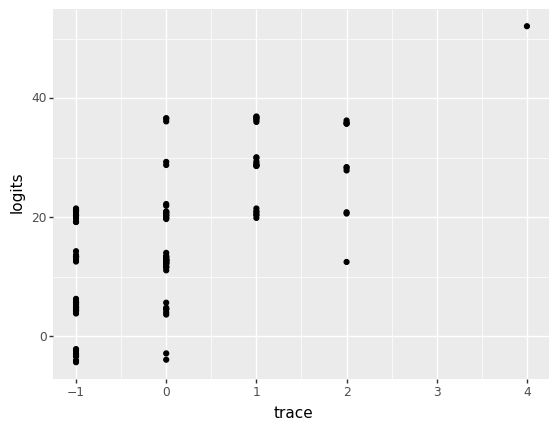

<ggplot: (688336878)>

In [39]:


lperm = "(0, 1, 2, 3, 4)"
rperm = "(1, 0, 2, 3, 4)"
target = "(1, 0, 2, 3, 4)"


df = full_df.filter(
    (pl.col('target_perm') == target) &
    (pl.col('left_perm') == lperm) &
    (pl.col('right_perm') == rperm)
)

ggplot(df, aes(x='trace', y='logits')) + geom_point()

In [40]:
perms = [
    Permutation(eval(p)) for p in
    df.filter(pl.col('logits') < 25).filter(pl.col('logits') > 18)['perm'].to_list()
]

In [41]:
tp = Permutation((1, 0, 2, 3, 4))

[(tp * p.inverse).conjugacy_class for p in perms]

[(3, 2),
 (3, 2),
 (4, 1),
 (4, 1),
 (3, 2),
 (2, 1, 1, 1),
 (4, 1),
 (4, 1),
 (2, 1, 1, 1),
 (4, 1),
 (4, 1),
 (4, 1),
 (4, 1),
 (3, 2),
 (5,),
 (3, 1, 1),
 (5,),
 (5,),
 (5,),
 (3, 1, 1),
 (3, 1, 1),
 (3, 1, 1),
 (3, 1, 1),
 (2, 2, 1),
 (5,),
 (2, 2, 1),
 (2, 2, 1),
 (3, 1, 1),
 (5,),
 (5,),
 (5,),
 (2, 2, 1)]

In [42]:
unembed = (model.unembed.weight - model.unembed.weight.mean(dim=1, keepdim=True))

In [43]:



U, S, Vh = torch.linalg.svd(unembed, full_matrices=False)

In [44]:
print(f'U={U.shape}')
print(f'S={S.shape}')
print(f'Vh={Vh.shape}')


U=torch.Size([120, 120])
S=torch.Size([120])
Vh=torch.Size([120, 128])


In [45]:
((U @ torch.diag(S) @ Vh) - model.unembed.weight).abs().max()

tensor(0.0771, grad_fn=<MaxBackward1>)

In [46]:
df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)

In [47]:
df.melt(id_vars='irrep').filter(pl.col('irrep') == '(5,)').filter(pl.col('value') > 0.5)

irrep,variable,value
str,str,f32
"""(5,)""","""dim5""",0.999073
"""(5,)""","""dim7""",0.998929
"""(5,)""","""dim41""",0.999741
"""(5,)""","""dim44""",0.99974
"""(5,)""","""dim98""",0.999804
"""(5,)""","""dim102""",0.999741
"""(5,)""","""dim107""",0.99974
"""(5,)""","""dim110""",0.999741
"""(5,)""","""dim112""",0.999804


In [48]:
unembed[:, 5]

tensor([ 0.3208,  0.3475,  0.3335,  0.3159,  0.3345,  0.3386,  0.3444,  0.3622,
         0.3734,  0.3354,  0.3508,  0.3327,  0.3248,  0.3389,  0.3170,  0.3431,
         0.3080,  0.3548,  0.3518,  0.3074,  0.3345,  0.2990,  0.3287,  0.3241,
         0.3317,  0.3457,  0.3140,  0.3513,  0.3481,  0.3246,  0.3738,  0.3124,
         0.3281,  0.3185,  0.3231,  0.3222,  0.3401,  0.3265,  0.3190,  0.3522,
         0.3450,  0.3303,  0.3279,  0.3337,  0.3543,  0.3447,  0.3408,  0.3425,
         0.3419,  0.3304,  0.3481,  0.3514,  0.3549,  0.3050,  0.3176,  0.3199,
         0.3422,  0.3288,  0.3479,  0.3539, -0.4509, -0.4589, -0.4382, -0.4382,
        -0.4426, -0.4355, -0.4332, -0.4301, -0.4387, -0.4317, -0.4307, -0.4430,
        -0.4476, -0.4658, -0.4584, -0.4757, -0.4517, -0.4509, -0.4530, -0.4606,
        -0.4539, -0.4628, -0.4705, -0.4691, -0.4546, -0.4482, -0.4609, -0.4525,
        -0.4776, -0.4638, -0.4497, -0.4414, -0.4471, -0.4562, -0.4500, -0.4674,
        -0.4553, -0.4578, -0.4558, -0.44

In [49]:
full_df = full_df.with_columns(pl.col('trace').round().cast(pl.Int32))

In [50]:
s5_iter = product(full_group, full_group)
    


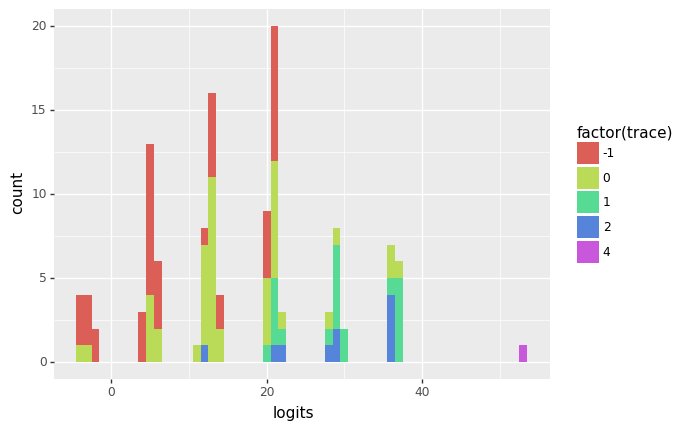

<ggplot: (706683706)>

In [51]:
from plotnine import geom_smooth


lp, rp = next(s5_iter)
tp = lp * rp
df = full_df.filter(
    (pl.col('target_perm') == str(tp)) &
    (pl.col('left_perm') == str(lp)) &
    (pl.col('right_perm') == str(rp))
)

ggplot(df, aes(x='logits', fill='factor(trace)')) + geom_histogram(binwidth=1)

In [52]:
from functools import reduce


s4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
        [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
        [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
        [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
        [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
    ]
}

a4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
        [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
        [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
        [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
        [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

    ]
}

def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, index, sg_name):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'subgroup': f'{sg_name}_{index}', f'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)


def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return reduce(_coset_join, data)


def make_right_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return reduce(_coset_join, data)



def make_right_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


def make_left_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


frobenius_groups = {
    "order": 20,
    "copies": 6,
    "generators": [
        [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
        [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
        [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
        [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
        [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
        [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
    ]
    
}


In [72]:

def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


def coset_analysis(data, coset_df):
    base_df = (
        data
        .melt(id_vars=['layer', 'permutation', 'irrep'])
        .groupby(['layer', 'permutation', 'variable'])
        .agg(pl.col('value').sum())
    )
    summary_df = (
        base_df
        .groupby(['layer', 'variable'])
        .agg([
            pl.col('value').mean().alias('mean'),
            pl.col('value').min().alias('min'),
            pl.col('value').max().alias('max'),
            pl.col('value').var().alias('full_var'),
            (pl.col('value') ** 2).sum().alias('two_norm')
        ])
    )
    
    df = (
        base_df
        ##### Join against _all_ cosets, this is a many-to-1 join
        .join(coset_df, on='permutation', how='inner')
        .groupby(['layer', 'variable', 'subgroup', 'coset_rep'])
        .agg([
            # Get the average value and variance of the (per dim) activations over a single coset
            # Small variance --> activations highly concentrated on the coset
            pl.col('value').var().alias('coset_var'),
            pl.col('value').mean().alias('coset_mean')
        ])
        .sort(['variable', 'subgroup', 'coset_rep'])
        .groupby(['layer', 'variable', 'subgroup'], maintain_order=True)
        # Sum all the variances of the cosets for one subgroup
        .agg(pl.col('coset_var').sum().alias('coset_cond_var'))
        # Sort ascending by coset variance
        .sort(['variable', 'coset_cond_var'])
        .groupby(['layer', 'variable'], maintain_order=True)
        .agg([
            # 
            pl.col('subgroup').first(),
            pl.col('coset_cond_var').first().alias('min_coset_var'),
            (pl.col('coset_cond_var').mean() - pl.col('coset_cond_var').first()).alias('sanity')
        ])
        .join(summary_df, on=['layer', 'variable'])
        .sort('subgroup')
    )
    return df
        
        
        

def _make_one_coset_df(sg_def, n, name):
        all_subgroups = [generate_subgroup(gen) for gen in sg_def['generators']]
        right_coset_df = make_right_full_coset_df(all_subgroups, n, name)
        left_coset_df = make_left_full_coset_df(all_subgroups, n, name)
        return left_coset_df, right_coset_df
        
        

def make_full_coset_df():
        frob_groups = {
            "order": 20,
            "copies": 6,
            "generators": [
                [(0, 2, 3, 4, 1), (1, 2, 4, 0, 3)],
                [(0, 2, 3, 4, 1), (1, 4, 3, 0, 2)],
                [(0, 2, 4, 1, 3), (1, 2, 3, 4, 0)],
                [(0, 2, 4, 1, 3), (1, 3, 4, 2, 0)],
                [(0, 3, 4, 2, 1), (1, 3, 0, 4, 2)],
                [(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]
            ]
        }
        d8_subgroups = {
            "order": 8,
            "copies": 15,
            "generators": [
                [(0, 2, 3, 4, 1), (0, 1, 4, 3, 2)],
                [(0, 2, 4, 1, 3), (0, 1, 3, 2, 4)],
                [(0, 3, 4, 2, 1), (0, 1, 2, 4, 3)],
                [(1, 2, 3, 0, 4), (0, 3, 2, 1, 4)],
                [(1, 2, 4, 3, 0), (0, 4, 2, 3, 1)],
                [(1, 3, 0, 2, 4), (0, 2, 1, 3, 4)],
                [(1, 3, 2, 4, 0), (0, 4, 2, 3, 1)],
                [(1, 4, 0, 3, 2), (0, 2, 1, 3, 4)],
                [(1, 4, 2, 0, 3), (0, 3, 2, 1, 4)],
                [(2, 1, 3, 4, 0), (0, 1, 4, 3, 2)],
                [(2, 1, 4, 0, 3), (0, 1, 3, 2, 4)],
                [(2, 3, 1, 0, 4), (0, 1, 3, 2, 4)],
                [(2, 4, 1, 3, 0), (0, 1, 4, 3, 2)],
                [(3, 1, 4, 2, 0), (0, 1, 2, 4, 3)],
                [(3, 4, 2, 1, 0), (0, 1, 2, 4, 3)]
            ]
        }
        d10_subgroups = {
            "order": 10,
            "copies": 6,
            "generators": [
                [(1, 2, 3, 4, 0), (0, 4, 3, 2, 1)],
                [(1, 2, 4, 0, 3), (0, 3, 4, 1, 2)],
                [(1, 3, 0, 4, 2), (0, 2, 1, 4, 3)],
                [(1, 3, 4, 2, 0), (0, 4, 3, 2, 1)],
                [(1, 4, 0, 2, 3), (0, 2, 1, 4, 3)],
                [(1, 4, 3, 0, 2), (0, 3, 4, 1, 2)]
            ]
        }
        s3xs2_subgroups = {
            "order": 12,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4), (1, 0, 2, 3, 4)], #1
                [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3), (2, 1, 0, 3, 4)], #2
                [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4), (3, 1, 2, 0, 4)], #3
                [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4), (4, 1, 2, 3, 0)], #4
                [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4), (0, 2, 1, 3, 4)], #5
                [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4), (0, 3, 2, 1, 4)], #6
                [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4), (0, 4, 2, 3, 1)], #7
                [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4), (0, 1, 3, 2, 4)], #8
                [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4), (0, 1, 4, 3, 2)], #9
                [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4), (0, 1, 2, 4, 3)], #10
            ]

        }
        s4_subgroups = {
            "order": 12,
            "copies": 5,
            "generators": [
                [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
                [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
                [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
                [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
                [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
            ]
        }

        s3_subgroups = {
            "order": 6,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (0, 1, 3, 2, 4)], #1  fix 0 1
                [(0, 3, 2, 4, 1), (0, 1, 2, 4, 3)], #2  fix 0 2
                [(0, 2, 4, 3, 1), (0, 2, 1, 3, 4)], #3  fix 0 3
                [(0, 2, 3, 1, 4), (0, 2, 1, 3, 4)], #4  fix 0 4
                [(3, 1, 2, 4, 0), (3, 1, 2, 0, 4)], #5  fix 1 2
                [(2, 1, 4, 3, 0), (2, 1, 0, 3, 4)], #6  fix 1 3
                [(2, 1, 3, 0, 4), (2, 1, 0, 3, 4)], #7  fix 1 4
                [(1, 4, 2, 3, 0), (1, 0, 2, 3, 4)], #8  fix 2 3
                [(1, 3, 2, 0, 4), (1, 0, 2, 3, 4)], #9  fix 2 4
                [(1, 2, 0, 3, 4), (1, 0, 2, 3, 4)], #10 fix 3 4
            ]
        }
        
        twisted_s3_subgroups = {
            "order": 6,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (1, 0, 2, 4, 3)],
                [(0, 2, 3, 1, 4), (4, 1, 3, 2, 0)],
                [(0, 2, 4, 3, 1), (3, 1, 4, 0, 2)],
                [(0, 3, 2, 4, 1), (2, 1, 0, 4, 3)],
                [(1, 2, 0, 3, 4), (0, 2, 1, 4, 3)],
                [(1, 3, 2, 0, 4), (0, 3, 4, 1, 2)],
                [(1, 4, 2, 3, 0), (0, 4, 3, 2, 1)],
                [(2, 1, 3, 0, 4), (0, 4, 3, 2, 1)],
                [(2, 1, 4, 3, 0), (0, 3, 4, 1, 2)],
                [(3, 1, 2, 4, 0), (0, 2, 1, 4, 3)]
            ]
        }
        a4_subgroups = {
            "order": 12,
            "copies": 5,
            "generators": [
                [(0, 2, 1, 4, 3), (0, 3, 1, 2, 4)], # 1 fix 0
                [(2, 1, 0, 4, 3), (0, 1, 4, 2, 3)], # 2 fix 1
                [(1, 0, 2, 4, 3), (3, 0, 2, 1, 4)], # 3 fix 2
                [(1, 0, 4, 3, 2), (2, 0, 1, 3, 4)], # 4 fix 3
                [(1, 0, 3, 2, 4), (2, 0, 1, 3, 4)], # 5 fix 4

            ]
        }
        z5_subgroups = {
            "order": 5,
            "copies": 6,
            "generators": [
                [(1, 2, 4, 0, 3)],
                [(1, 4, 3, 0, 2)],
                [(1, 2, 3, 4, 0)],
                [(1, 3, 4, 2, 0)],
                [(1, 3, 0, 4, 2)],
                [(1, 4, 0, 2, 3)]
            ]
        }
        z6_subgroups = {
            "order": 6,
            "copies": 10,
            "generators": [
                [(0, 1, 3, 4, 2), (1, 0, 2, 3, 4)], #1  fix 0 1
                [(0, 3, 2, 4, 1), (2, 1, 0, 3, 4)], #2  fix 0 2
                [(0, 2, 4, 3, 1), (3, 1, 2, 0, 4)], #3  fix 0 3
                [(0, 2, 3, 1, 4), (4, 1, 2, 3, 0)], #4  fix 0 4
                [(3, 1, 2, 4, 0), (0, 2, 1, 3, 4)], #5  fix 1 2
                [(2, 1, 4, 3, 0), (0, 3, 2, 1, 4)], #6  fix 1 3
                [(2, 1, 3, 0, 4), (0, 4, 2, 3, 1)], #7  fix 1 4
                [(1, 4, 2, 3, 0), (0, 1, 3, 2, 4)], #8  fix 2 3
                [(1, 3, 2, 0, 4), (0, 1, 4, 3, 2)], #9  fix 2 4
                [(1, 2, 0, 3, 4), (0, 1, 2, 4, 3)], #10 fix 3 4
            ]
        }
        a5_subgroups = {
            "order": 60,
            "copies": 1,
            "generators": [[(4, 0, 1, 2, 3), (2, 0, 1, 3, 4)]]
        }
        
        left_a5_df, right_a5_df = _make_one_coset_df(a5_subgroups, 5, 'a5')
        left_z6_df, right_z6_df = _make_one_coset_df(z6_subgroups, 5, 'z6')
        left_z5_df, right_z5_df = _make_one_coset_df(z5_subgroups, 5, 'z5')
        left_a4_df, right_a4_df = _make_one_coset_df(a4_subgroups, 5, 'a4')
        left_s4_df, right_s4_df = _make_one_coset_df(s4_subgroups, 5, 's4')
        left_s3_df, right_s3_df = _make_one_coset_df(s3_subgroups, 5, 's3')
        left_frob_df, right_frob_df = _make_one_coset_df(frob_groups, 5, 'frob20')
        left_s3xs2_df, right_s3xs2_df = _make_one_coset_df(s3xs2_subgroups, 5, 's3xs2')
        left_d8_df, right_d8_df = _make_one_coset_df(s3xs2_subgroups, 5, 'd8')
        left_d10_df, right_d10_df = _make_one_coset_df(s3xs2_subgroups, 5, 'd10')
        left_twisteds3_df, right_twisteds3_df = _make_one_coset_df(twisted_s3_subgroups, 5, 'twisteds3')
        
        
        left_df = pl.concat([
            left_a5_df, left_z6_df, left_z5_df, left_a4_df, left_s4_df,
            left_s3_df, left_frob_df, left_s3xs2_df, left_d8_df, left_d10_df,
            left_twisteds3_df
        ])
        right_df = pl.concat([
            right_a5_df, right_z6_df, right_z5_df, right_a4_df, right_s4_df, 
            right_s3_df, right_frob_df, right_s3xs2_df, right_d8_df, right_d10_df,
            right_twisteds3_df
        ])
        
        return left_df, right_df
                


def transpose_power_df(data):
    irreps = data['irrep'].to_list()
    return (
        data
        .select(pl.exclude('irrep'))
        .transpose(
            include_header=True,
            header_name='variable', 
            column_names=irreps)
    )


def fp_sort_key(fp):
    last_part = fp.parts[-1].strip('.pth')
    if last_part == 'full_run':
        return 2 ** 10000
    else:
        return int(last_part)
    
    
def _analysis(model, perms, full_left_coset_df, full_right_coset_df):
    lperms, rperms, targets = perms
    
    logits, cache = model.run_with_cache(lperms, rperms)
    
    original_loss = loss_fn(logits, targets).mean()
    
    linear_acts = cache['hook_linear']
    S5 = Symmetric(5)
    
    config = model_run['config']
    embed_dim = config['embed_dim']
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    #unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)
    
        
    lpower_df = transpose_power_df(lpower_df)
    rpower_df = transpose_power_df(rpower_df)
    #unembed_power_df = transpose_power_df(unembed_power_df)
    
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df], how='vertical')
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    
    full_left_coset_df, full_right_coset_df = make_full_coset_df()

    left_perm_coset_df = coset_analysis(llinear_df, full_right_coset_df)
    right_perm_coset_df = coset_analysis(rlinear_df, full_left_coset_df)

    left_perm_coset_df = (
        left_perm_coset_df
        .select(pl.exclude(['sanity']))
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('subgroup').str.split(by='_').list.get(0)
        )
    )
        

    right_perm_coset_df = (
        right_perm_coset_df
        .select(pl.exclude(['sanity']))
        .with_columns(
            coset_var_ratio = (pl.col('min_coset_var') / pl.col('full_var')),
            subgroup_class = pl.col('subgroup').str.split(by='_').list.get(0)
        )
    )
    
    left_right_df = pl.concat([left_perm_coset_df, right_perm_coset_df])
    
    left_perm_coset_df = left_perm_coset_df.rename({
        'subgroup': 'left_subgroup',
        'mean': 'left_mean_preactivation',
        'max': 'left_max_preactivation',
        'full_var': 'left_full_var',
        'two_norm': 'left_two_norm',
        'min_coset_var': 'left_min_coset_var',
        'coset_var_ratio': 'left_coset_var_ratio',
        'subgroup_class': 'left_subgroup_class'
        
    })
    
    
    right_perm_coset_df = right_perm_coset_df.rename({
        'subgroup': 'right_subgroup',
        'mean': 'right_mean_preactivation',
        'max': 'right_max_preactivation',
        'full_var': 'right_full_var',
        'two_norm': 'right_two_norm',
        'min_coset_var': 'right_min_coset_var',
        'coset_var_ratio': 'right_coset_var_ratio',
        'subgroup_class': 'right_subgroup_class'
    })
    
    linear_coset_df = (
        left_perm_coset_df
        .join(right_perm_coset_df, on='variable', how='inner')
        .with_columns([
            ('(' + pl.col('left_subgroup') + ', ' + pl.col('right_subgroup') + ')').alias('subgroup_pair'),
            ((pl.col('left_min_coset_var') + pl.col('right_min_coset_var'))/ 2).alias('coset_var'),
            ((pl.col('left_coset_var_ratio') + pl.col('right_coset_var_ratio'))/ 2).alias('coset_var_ratio'),
            ((pl.col('left_two_norm') + pl.col('right_two_norm'))/ 2).alias('two_norm'),
            (
                pl.when(pl.col('left_subgroup_class') == pl.col('right_subgroup_class'))
                .then(pl.col('left_subgroup_class'))
                .otherwise(pl.lit('mixed'))
            ).alias('subgroup_class')
        ]).sort('subgroup_pair')
    )
    return linear_coset_df, left_right_df
    

def model_cosets(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    #checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    #checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    

    
    #for epoch, ckpt_fp in zip(checkpoint_epochs, checkpoint_paths):
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])
    _analysis(model, (lperms, rperms, targets), full_left_coset_df, full_right_coset_df)       
    return _analysis(model, (lperms, rperms, targets), full_left_coset_df, full_right_coset_df)

In [73]:
from sngrok.groups import generate_subgroup, Symmetric


linear_coset_df, lr_df = model_cosets(0)

In [74]:
linear_coset_df.head()

layer,variable,left_subgroup,left_min_coset_var,left_mean_preactivation,min,left_max_preactivation,left_full_var,left_two_norm,left_coset_var_ratio,left_subgroup_class,layer_right,right_subgroup,right_min_coset_var,right_mean_preactivation,min_right,right_max_preactivation,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,subgroup_pair,coset_var,coset_var_ratio,two_norm,subgroup_class
str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,str
"""left_linear""","""dim12""","""a4_0""",2.3787e-8,0.000001,-0.624274,0.624125,0.130133,15.485816,1.8279e-7,"""a4""","""right_linear""","""a4_0""",2.0304e-8,0.000007,-0.624069,0.624243,0.130117,15.483948,1.5604e-7,"""a4""","""(a4_0, a4_0)""",2.2045e-8,1.6942e-7,15.484882,"""a4"""
"""left_linear""","""dim26""","""a4_0""",0.0,1.9257e-30,-4.3385e-25,4.3385e-25,0.0,0.0,NaN,"""a4""","""right_linear""","""a4_0""",0.0,-1.2019e-30,-4.3387e-25,4.3392e-25,0.0,0.0,NaN,"""a4""","""(a4_0, a4_0)""",0.0,NaN,0.0,"""a4"""
"""left_linear""","""dim118""","""a4_0""",0.0,6.6226e-29,-1.8954e-23,1.8955e-23,0.0,0.0,NaN,"""a4""","""right_linear""","""a4_0""",0.0,7.8515e-29,-1.8960e-23,1.8959e-23,0.0,0.0,NaN,"""a4""","""(a4_0, a4_0)""",0.0,NaN,0.0,"""a4"""
"""left_linear""","""dim56""","""a4_0""",0.0,-9.6996e-40,-5.0388e-35,5.1889e-35,0.0,0.0,NaN,"""a4""","""right_linear""","""a4_0""",0.0,-2.3160e-39,-6.1462e-35,6.0019e-35,0.0,0.0,NaN,"""a4""","""(a4_0, a4_0)""",0.0,NaN,0.0,"""a4"""
"""left_linear""","""dim41""","""a5_0""",1.1563e-7,-0.000002,-2.095427,2.095383,4.425695,526.657715,2.6126e-8,"""a5""","""right_linear""","""a5_0""",4.4907e-8,0.000011,-2.095262,2.095039,4.42496,526.570312,1.0149e-8,"""a5""","""(a5_0, a5_0)""",8.0267e-8,1.8137e-8,526.614014,"""a5"""


In [67]:
lr_df.filter(pl.col('max') > 2).sort(['layer', 'subgroup_class'])

layer,variable,subgroup,min_coset_var,mean,min,max,full_var,two_norm,coset_var_ratio,subgroup_class
str,str,str,f32,f32,f32,f32,f32,f32,f32,str
"""left_linear""","""dim44""","""a5_0""",1.3096e-7,-0.000002,-2.096127,2.096031,4.428467,526.987488,2.9573e-8,"""a5"""
"""left_linear""","""dim98""","""a5_0""",1.4113e-7,0.000003,-2.349113,2.349199,5.562597,661.949158,2.5370e-8,"""a5"""
"""left_linear""","""dim114""","""a5_0""",1.3921e-7,0.000004,-2.350034,2.350078,5.566896,662.46051,2.5007e-8,"""a5"""
"""left_linear""","""dim5""","""a5_0""",1.3695e-7,-0.000004,-2.627635,2.627644,6.959851,828.222107,1.9677e-8,"""a5"""
"""left_linear""","""dim7""","""a5_0""",1.3324e-7,0.000004,-2.627504,2.627573,6.959307,828.157349,1.9146e-8,"""a5"""
"""left_linear""","""dim112""","""a5_0""",1.2928e-7,0.000003,-2.349576,2.349646,5.564887,662.221436,2.3231e-8,"""a5"""
"""left_linear""","""dim41""","""a5_0""",1.1563e-7,-0.000002,-2.095427,2.095383,4.425695,526.657593,2.6126e-8,"""a5"""
"""left_linear""","""dim110""","""a5_0""",1.4065e-7,-0.000002,-2.096158,2.096125,4.428392,526.978638,3.1761e-8,"""a5"""
"""left_linear""","""dim107""","""a5_0""",1.4498e-7,-0.000002,-2.09643,2.096417,4.429451,527.104553,3.2731e-8,"""a5"""


In [69]:
lr_df.filter(
    (pl.col('subgroup') == 's4_4') &
    (pl.col('layer') == 'left_linear') & 
    (pl.col('max') > 1.5)
)
    

layer,variable,subgroup,min_coset_var,mean,min,max,full_var,two_norm,coset_var_ratio,subgroup_class
str,str,str,f32,f32,f32,f32,f32,f32,f32,str
"""left_linear""","""dim123""","""s4_4""",7.0346e-7,0.000137,-4.948169,4.950406,12.231626,1455.563477,5.7512e-8,"""s4"""
"""left_linear""","""dim1""","""s4_4""",7.6305e-7,0.000136,-4.880073,4.882037,11.897548,1415.80835,6.4135e-8,"""s4"""
"""left_linear""","""dim42""","""s4_4""",0.000001,0.000204,-6.459516,6.462244,20.845516,2480.616211,5.2756e-8,"""s4"""
"""left_linear""","""dim65""","""s4_4""",6.2509e-7,-0.000118,-4.466717,4.464918,9.959133,1185.136475,6.2766e-8,"""s4"""
"""left_linear""","""dim108""","""s4_4""",5.1261e-7,0.000111,-4.257343,4.259061,9.054986,1077.543335,5.6610e-8,"""s4"""
"""left_linear""","""dim116""","""s4_4""",5.8647e-7,-0.000118,-4.471623,4.469875,9.981129,1187.754028,5.8757e-8,"""s4"""
"""left_linear""","""dim78""","""s4_4""",7.0854e-7,-0.000119,-4.469829,4.46808,9.973319,1186.825073,7.1043e-8,"""s4"""
"""left_linear""","""dim119""","""s4_4""",5.6708e-7,0.00011,-4.25311,4.254758,9.036757,1075.374023,6.2753e-8,"""s4"""
"""left_linear""","""dim121""","""s4_4""",7.5409e-7,-0.00016,-5.520169,5.517869,15.210842,1810.090332,4.9576e-8,"""s4"""


In [77]:
(
    linear_coset_df
    .filter((pl.col('left_max_preactivation') > 1.5) & (pl.col('right_max_preactivation') > 1.5))
    .filter(pl.col('subgroup_class') == 's4')
    .groupby('subgroup_pair').count()
    .sort('count')
)

subgroup_pair,count
str,u32
"""(s4_1, s4_4)""",2
"""(s4_2, s4_4)""",2
"""(s4_1, s4_0)""",2
"""(s4_2, s4_3)""",2
"""(s4_2, s4_1)""",2
"""(s4_1, s4_1)""",2
"""(s4_2, s4_0)""",2
"""(s4_3, s4_4)""",3
"""(s4_4, s4_1)""",3


In [121]:
variables = (
    linear_coset_df
    .filter((pl.col('left_max_preactivation') > 1.5) & (pl.col('right_max_preactivation') > 1.5))
    .filter(pl.col('subgroup_pair') == '(s4_0, s4_0)')
)['variable'].to_list()


dims = tuple(sorted([int(v[3:]) for v in variables]))
dims

(15, 63, 64, 70, 79, 100, 103)

In [122]:
from torch.nn.functional import relu

logits_s4_0 = (model.unembed.weight[:, dims] @ relu(linear_acts[:, dims].T)).T

In [98]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .list.eval((pl.element() == element).cast(pl.UInt32))
        .list.arg_max().cast(pl.Utf8)
    )

In [123]:
logit_s4_0_df = pl.concat(
    [
        perm_df,
        pl.DataFrame(
            logits_s4_0.detach().numpy(),
            schema=[str(perm) for perm in full_group]
        )
    ],
    how='horizontal'
)
logit_s4_0_df.head()

left_perm,right_perm,target_perm,"(0, 1, 2, 3, 4)","(0, 1, 3, 4, 2)","(0, 1, 4, 2, 3)","(0, 2, 1, 4, 3)","(0, 2, 3, 1, 4)","(0, 2, 4, 3, 1)","(0, 3, 1, 2, 4)","(0, 3, 2, 4, 1)","(0, 3, 4, 1, 2)","(0, 4, 1, 3, 2)","(0, 4, 2, 1, 3)","(0, 4, 3, 2, 1)","(1, 0, 2, 4, 3)","(1, 0, 3, 2, 4)","(1, 0, 4, 3, 2)","(1, 2, 0, 3, 4)","(1, 2, 3, 4, 0)","(1, 2, 4, 0, 3)","(1, 3, 0, 4, 2)","(1, 3, 2, 0, 4)","(1, 3, 4, 2, 0)","(1, 4, 0, 2, 3)","(1, 4, 2, 3, 0)","(1, 4, 3, 0, 2)","(2, 0, 1, 3, 4)","(2, 0, 3, 4, 1)","(2, 0, 4, 1, 3)","(2, 1, 0, 4, 3)","(2, 1, 3, 0, 4)","(2, 1, 4, 3, 0)","(2, 3, 0, 1, 4)","(2, 3, 1, 4, 0)","(2, 3, 4, 0, 1)","(2, 4, 0, 3, 1)",…,"(1, 4, 3, 2, 0)","(2, 0, 1, 4, 3)","(2, 0, 3, 1, 4)","(2, 0, 4, 3, 1)","(2, 1, 0, 3, 4)","(2, 1, 3, 4, 0)","(2, 1, 4, 0, 3)","(2, 3, 0, 4, 1)","(2, 3, 1, 0, 4)","(2, 3, 4, 1, 0)","(2, 4, 0, 1, 3)","(2, 4, 1, 3, 0)","(2, 4, 3, 0, 1)","(3, 0, 1, 2, 4)","(3, 0, 2, 4, 1)","(3, 0, 4, 1, 2)","(3, 1, 0, 4, 2)","(3, 1, 2, 0, 4)","(3, 1, 4, 2, 0)","(3, 2, 0, 1, 4)","(3, 2, 1, 4, 0)","(3, 2, 4, 0, 1)","(3, 4, 0, 2, 1)","(3, 4, 1, 0, 2)","(3, 4, 2, 1, 0)","(4, 0, 1, 3, 2)","(4, 0, 2, 1, 3)","(4, 0, 3, 2, 1)","(4, 1, 0, 2, 3)","(4, 1, 2, 3, 0)","(4, 1, 3, 0, 2)","(4, 2, 0, 3, 1)","(4, 2, 1, 0, 3)","(4, 2, 3, 1, 0)","(4, 3, 0, 1, 2)","(4, 3, 1, 2, 0)","(4, 3, 2, 0, 1)"
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",-0.000438,-0.000459,-0.000484,-0.000467,-0.000438,-0.000443,-0.000447,-0.000454,-0.00044,-0.000453,-0.000457,-0.000459,0.00017,0.000203,0.000218,0.000212,0.000138,0.00016,0.000188,0.000161,0.00015,0.000202,0.000173,0.000172,0.000235,0.000187,0.000214,0.00019,0.000167,0.000183,0.000229,0.000153,0.000162,0.00023,…,0.000124,0.000143,0.000205,0.000186,0.000205,0.000119,0.000132,0.000179,0.000147,0.000173,0.000194,0.000156,0.000131,0.000189,0.000184,0.000228,0.000186,0.000156,0.000139,0.000214,0.00015,0.000163,0.000165,0.000144,0.000171,0.000181,0.000173,0.000152,0.00015,0.000158,0.000143,0.000193,0.000128,0.000162,0.000199,0.000118,0.000146
"""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…","""(0, 1, 3, 4, 2…",-0.000373,-0.000391,-0.000412,-0.000397,-0.000372,-0.000377,-0.000381,-0.000386,-0.000374,-0.000385,-0.000389,-0.000391,0.000145,0.000173,0.000186,0.00018,0.000117,0.000136,0.00016,0.000137,0.000127,0.000172,0.000148,0.000146,0.0002,0.000159,0.000183,0.000162,0.000142,0.000156,0.000195,0.00013,0.000138,0.000196,…,0.000105,0.000122,0.000175,0.000158,0.000175,0.000101,0.000112,0.000153,0.000125,0.000148,0.000165,0.000133,0.000111,0.000161,0.000157,0.000194,0.000158,0.000132,0.000118,0.000182,0.000128,0.000139,0.00014,0.000123,0.000145,0.000154,0.000147,0.000129,0.000127,0.000134,0.000122,0.000164,0.000109,0.000138,0.000169,0.000101,0.000124
"""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…","""(0, 1, 4, 2, 3…",-0.000721,-0.000757,-0.000797,-0.000769,-0.000721,-0.00073,-0.000737,-0.000748,-0.000724,-0.000746,-0.000754,-0.000757,0.000281,0.000335,0.00036,0.000349,0.000227,0.000263,0.00031,0.000266,0.000247,0.000333,0.000286,0.000283,0.000387,0.000308,0.000353,0.000314,0.000276,0.000301,0.000378,0.000252,0.000267,0.000379,…,0.000204,0.000236,0.000338,0.000306,0.000338,0.000196,0.000217,0.000296,0.000242,0.000286,0.000319,0.000257,0.000215,0.000311,0.000303,0.000376,0.000306,0.000256,0.000229,0.000353,0.000247,0.000269,0.000272,0.000237,0.000281,0.000298,0.000284,0.00025,0.000247,0.00026,0.000236,0.000318,0.000211,0.000267,0.000328,0.000195,0.00024
"""(0, 1, 2, 3, 4…","""(0, 2, 1, 4, 3…","""(0, 2, 1, 4, 3…",-0.001216,-0.001276,-0.001343,-0.001297,-0.001215,-0.001231,-0.001242,-0.00126,-0.001221,-0.001258,-0.001271,-0.001276,0.000474,0.000565,0.000606,0.000588,0.000382,0.000443,0.000523,0.000448,0.000416,0.000562,0

In [127]:

df0 = (
    logit_s4_0_df
    .melt(id_vars=['left_perm', 'right_perm', 'target_perm'], variable_name='logit_perm')
    .with_columns([
            pl.col('logit_perm').str.extract_all('([0-4])').alias('logit_vals'),
            pl.col('target_perm').str.extract_all('([0-4])').alias('target_vals'),
        ])
        .with_columns([
            get_index_of('target_vals', '0').alias('target_index_of_0'),
            get_index_of('target_vals', '1').alias('target_index_of_1'),
            get_index_of('target_vals', '2').alias('target_index_of_2'),
            get_index_of('target_vals', '3').alias('target_index_of_3'),
            get_index_of('target_vals', '4').alias('target_index_of_4'),
            get_index_of('logit_vals', '0').alias('logit_index_of_0'),
            get_index_of('logit_vals', '1').alias('logit_index_of_1'),
            get_index_of('logit_vals', '2').alias('logit_index_of_2'),
            get_index_of('logit_vals', '3').alias('logit_index_of_3'),
            get_index_of('logit_vals', '4').alias('logit_index_of_4'),
        ])
)

df4 = (
    logit_s4_4_df
    .melt(id_vars=['left_perm', 'right_perm', 'target_perm'], variable_name='logit_perm')
    .with_columns([
            pl.col('logit_perm').str.extract_all('([0-4])').alias('logit_vals'),
            pl.col('target_perm').str.extract_all('([0-4])').alias('target_vals'),
        ])
        .with_columns([
            get_index_of('target_vals', '0').alias('target_index_of_0'),
            get_index_of('target_vals', '1').alias('target_index_of_1'),
            get_index_of('target_vals', '2').alias('target_index_of_2'),
            get_index_of('target_vals', '3').alias('target_index_of_3'),
            get_index_of('target_vals', '4').alias('target_index_of_4'),
            get_index_of('logit_vals', '0').alias('logit_index_of_0'),
            get_index_of('logit_vals', '1').alias('logit_index_of_1'),
            get_index_of('logit_vals', '2').alias('logit_index_of_2'),
            get_index_of('logit_vals', '3').alias('logit_index_of_3'),
            get_index_of('logit_vals', '4').alias('logit_index_of_4'),
        ])
)

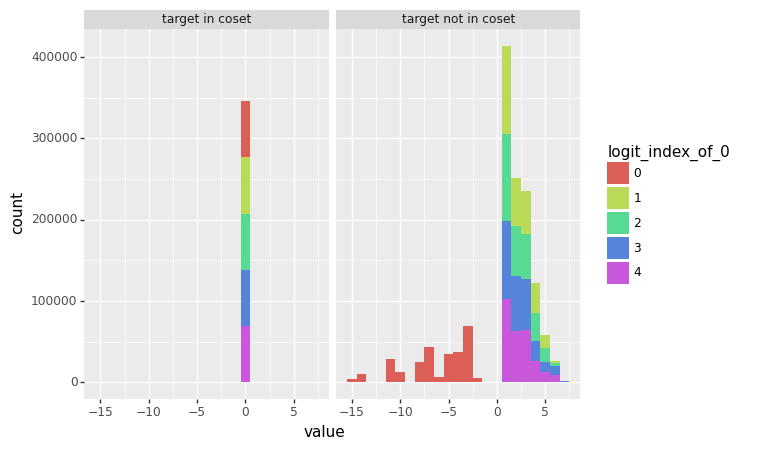

<ggplot: (1429669546)>

In [135]:
ggplot(
    df0.with_columns(pl.when(pl.col('target_index_of_0') == '0').then(pl.lit('target in coset')).otherwise(pl.lit('target not in coset')).alias('target_in_coset')),
    aes(x='value', fill='logit_index_of_0')
) + geom_histogram(binwidth=1) + facet_wrap('~target_in_coset')

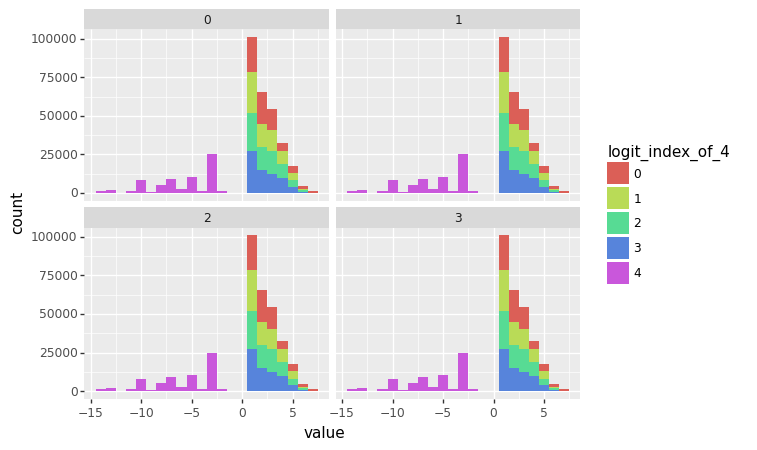

<ggplot: (1476830166)>

In [141]:
ggplot(
    #df4.with_columns(pl.when(pl.col('target_index_of_4') == '4').then(pl.lit('target in coset')).otherwise(pl.lit('target not in coset')).alias('target_in_coset')),
    df4.filter(pl.col('target_index_of_4') != '4'),
    aes(x='value', fill='logit_index_of_4')
) + geom_histogram(binwidth=1) + facet_wrap('~target_index_of_4')

In [173]:
trace_df2111 = pl.concat(
    [
        perm_df,
        pl.DataFrame(
            cube2111.detach().numpy(),
            schema=[str(perm) for perm in full_group]
        )
    ],
    how='horizontal'
)

trace_df = trace_df2111.melt(
    id_vars=['left_perm', 'right_perm', 'target_perm'],
    variable_name='logit_perm',
    value_name='trace'
).with_columns(pl.col('trace').round().cast(pl.Int32))

In [174]:


df = df4.join(trace_df, on=['left_perm', 'right_perm', 'target_perm', 'logit_perm'], how='inner')

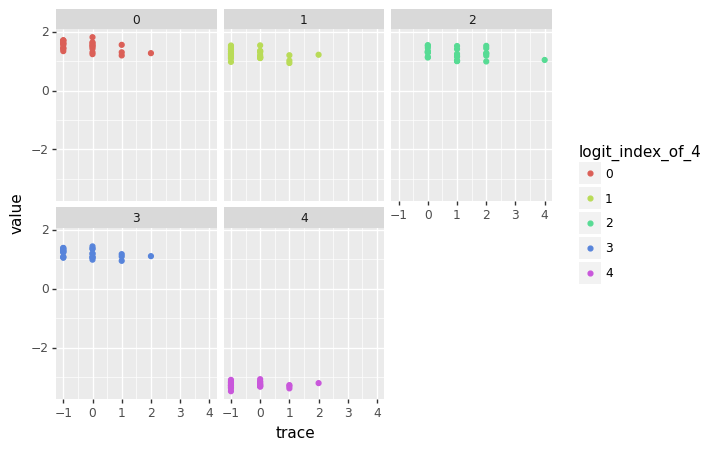

<ggplot: (706493627)>

In [176]:
from plotnine import geom_jitter

ggplot(
    df.filter((pl.col('target_perm') == "(0, 1, 4, 3, 2)") & (pl.col('left_perm') == "(0, 1, 2, 3, 4)") & (pl.col('right_perm') == "(0, 1, 4, 3, 2)") ),
    aes(x = 'trace', y = 'value', color='logit_index_of_4')
) + geom_point() + facet_wrap('~logit_index_of_4')

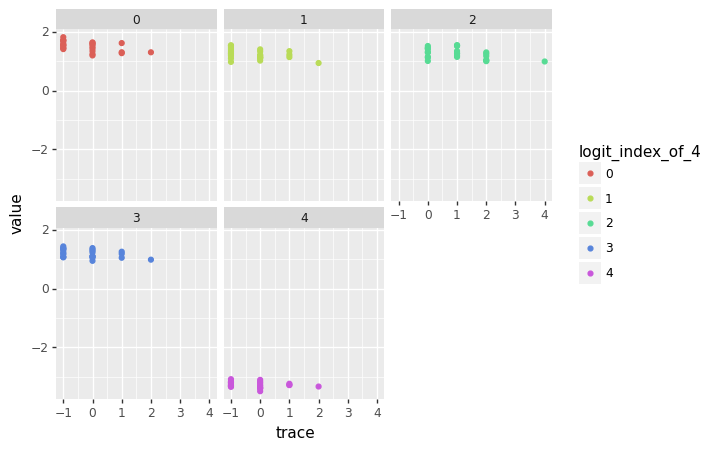

<ggplot: (735962770)>

In [178]:
ggplot(
    df.filter((pl.col('target_perm') == "(1, 0, 4, 3, 2)") & (pl.col('left_perm') == "(1, 0, 2, 3, 4)") & (pl.col('right_perm') == "(0, 1, 4, 3, 2)") ),
    aes(x = 'trace', y = 'value', color='logit_index_of_4')
) + geom_point() + facet_wrap('~logit_index_of_4') 

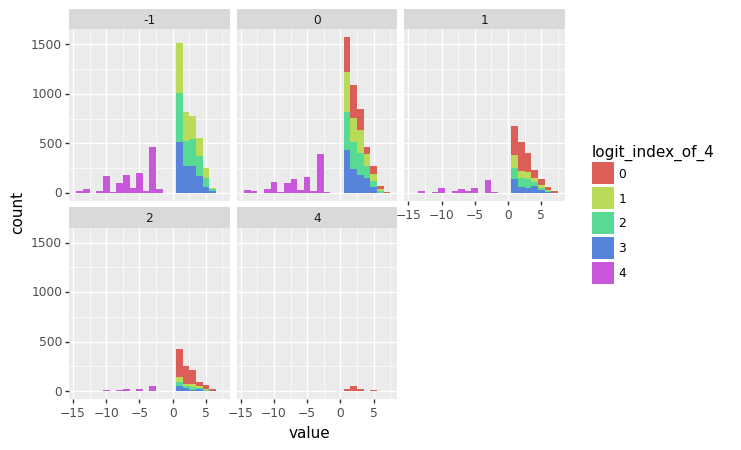

<ggplot: (1183051170)>

In [182]:
ggplot(
    df.filter(pl.col('target_perm') == "(4, 0, 1, 2, 3)"),
    aes(x = 'value', fill='logit_index_of_4')
) + geom_histogram(binwidth=1) + facet_wrap('~trace') 

In [167]:
#df4.filter(pl.col('target_perm') == '(4, 0, 1, 2, 3)')
Permutation((0, 2, 3, 1, 4)) * Permutation((4, 2, 0, 1, 3))

(4, 0, 1, 2, 3)

In [161]:
df4.groupby('target_perm').agg([
    pl.col('value').mean().alias('mean_value'),
    pl.col('value').min().alias('min_value'),
    pl.col('value').max().alias('max_value'),
    pl.col('value').std().alias('sd_value')
]).filter(pl.col('target_perm').str.ends_with('4)')).sort('mean_value')

target_perm,mean_value,min_value,max_value,sd_value
str,f32,f32,f32,f32
"""(2, 0, 3, 1, 4…",0.000084,-0.002396,0.001248,0.000463
"""(1, 3, 2, 0, 4…",0.000085,-0.002785,0.00145,0.000476
"""(3, 0, 2, 1, 4…",0.000085,-0.002838,0.001478,0.000463
"""(1, 0, 2, 3, 4…",0.000085,-0.002945,0.001534,0.000477
"""(1, 2, 3, 0, 4…",0.000085,-0.002216,0.001154,0.000478
"""(1, 0, 3, 2, 4…",0.000087,-0.002707,0.00141,0.00049
"""(0, 2, 1, 3, 4…",0.000087,-0.00225,0.001171,0.000482
"""(2, 3, 0, 1, 4…",0.000087,-0.002382,0.00124,0.00048
"""(1, 3, 0, 2, 4…",0.000088,-0.002867,0.001493,0.000489


In [213]:
full_group = Permutation.full_group(5)
fixes0 = [p for p in full_group if p.sigma[0] == 0]
fixes1 = [p for p in full_group if p.sigma[1] == 1]
fixes2 = [p for p in full_group if p.sigma[2] == 2]
fixes3 = [p for p in full_group if p.sigma[3] == 3]
fixes4 = [p for p in full_group if p.sigma[4] == 4]

In [214]:
f0 = torch.zeros((120, 2))
f1 = torch.zeros((120, 2))
f2 = torch.zeros((120, 2))
f3 = torch.zeros((120, 2))
f4 =  torch.zeros((120, 2))
for i, p in enumerate(full_group):
    if p in fixes0:
        f0[i, 0] = 1.
    if p in fixes1:
        f1[i, 0] = 1.
    if p in fixes2:
        f2[i, 0] = 1.
    if p in fixes3:
        f3[i, 0] = 1.
    if p in fixes4:
        f4[i, 0] = 1.

        

In [215]:
f0_ft = slow_sn_ft_1d(f0, 5)
f0_ft[(2, 1, 1, 1)][0]

tensor([[15.0000,  8.6603,  6.1237,  4.7434],
        [ 8.6603,  5.0000,  3.5355,  2.7386],
        [ 6.1237,  3.5355,  2.5000,  1.9365],
        [ 4.7434,  2.7386,  1.9365,  1.5000]])

In [216]:
f1_ft = slow_sn_ft_1d(f1, 5)
f1_ft[(2, 1, 1, 1)][0]

tensor([[15.0000, -8.6603, -6.1237, -4.7434],
        [-8.6603,  5.0000,  3.5355,  2.7386],
        [-6.1237,  3.5355,  2.5000,  1.9365],
        [-4.7434,  2.7386,  1.9365,  1.5000]])

In [217]:
f2_ft = slow_sn_ft_1d(f2, 5)
f2_ft[(2, 1, 1, 1)][0]

tensor([[ 0.0000e+00,  0.0000e+00,  3.5763e-07,  0.0000e+00],
        [ 0.0000e+00,  2.0000e+01, -7.0711e+00, -5.4772e+00],
        [ 5.9605e-08, -7.0711e+00,  2.5000e+00,  1.9365e+00],
        [-2.7756e-17, -5.4772e+00,  1.9365e+00,  1.5000e+00]])

In [218]:
f3_ft = slow_sn_ft_1d(f3, 5)
f3_ft[(2, 1, 1, 1)][0]

tensor([[ 0.0000e+00,  2.3842e-07,  0.0000e+00,  1.1921e-07],
        [ 5.9605e-08, -1.6391e-07, -1.4901e-08,  5.9605e-08],
        [-4.0511e-17, -1.4901e-08,  2.2500e+01, -5.8095e+00],
        [-5.5511e-17,  5.9605e-08, -5.8095e+00,  1.5000e+00]])

In [219]:
torch.trace(f3_ft[(2, 1, 1, 1)][0])

tensor(24.)

In [211]:
f3.sum()

tensor(24.)

In [198]:
f1_ft = slow_sn_ft_1d(f1, 5)
f1_ft[(2, 1, 1, 1)][0]

NameError: name 'f2_ft' is not defined

In [233]:
full_fn = f0 + f1 + f2 + f3 + f4

In [226]:
full_fn_ft = slow_sn_ft_1d(total, 5)


In [227]:
full_fn_ft[(2, 1, 1, 1)]

tensor([[[ 3.0000e+01,  3.5763e-07,  5.9605e-08,  4.7684e-07],
         [-5.9605e-07,  3.0000e+01, -1.6391e-06,  4.7684e-07],
         [-2.3842e-07,  0.0000e+00,  3.0000e+01,  2.3842e-07],
         [ 0.0000e+00,  0.0000e+00,  9.5367e-07,  3.0000e+01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]])

In [250]:
irrep = SnIrrep(5, (2, 1, 1, 1)).matrix_representations()
full = full_fn[:, 0].numpy()

chars = np.asarray([np.trace(irrep[p.inverse.sigma]) for p in full_group])


In [251]:
np.dot(full, chars)

120.0

In [254]:
np.allclose(full, chars + np.ones((120,)))

True